# Modelos de predição de abandono de alunos do Departamento de Computação da UFS


### Esse trabalho engloba a análise, limpeza, tratamento, modelagem e otimização sobre os dados histórico-acadêmicos de alunos de Departamento de Computação da Universidade Federal de Sergipe

## Importar Bibliotecas

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from numpy import mean, std
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## Leitura dos Dados

In [70]:
df = pd.read_csv("extraction_data.csv")

## Visão Geral dos Dados

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,...,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
0,122,97,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,30,1964-05-14,PORTO ALEGRE/RS,TRANSFERÊNCIA COMPULSÓRIA,0,...,100.0,CANCELADO,DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO,1.79,4.537049,0.300,0.476704,0.300,0.530138,0.1611
1,215,167,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1980-05-11,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.69,4.537049,0.300,0.476704,0.367,0.530138,0.7366
2,348,285,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,19,1983-10-26,ARACAJU/SE,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.66,4.537049,0.300,0.476704,0.446,0.530138,0.8911
3,352,289,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1981-08-08,RIO DE JANEIRO/RJ,VESTIBULAR,0,...,100.0,CANCELADO,ABANDONO,6.71,4.537049,0.300,0.476704,0.411,0.530138,0.8273
4,414,351,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1986-02-10,ARACAJU/SE,VESTIBULAR,0,...,100.0,CONCLUÍDO,CONCLUÍDO,6.55,4.537049,0.325,0.476704,0.429,0.530138,0.9132


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2603 entries, 0 to 2602
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   curriculum_id                  2603 non-null   int64  
 1   student_id                     2603 non-null   int64  
 2   centro                         2603 non-null   object 
 3   department_name                2603 non-null   object 
 4   course_name                    2603 non-null   object 
 5   student_age_at_initial_period  2603 non-null   int64  
 6   birthday                       2603 non-null   object 
 7   birth_place                    2600 non-null   object 
 8   ingress_form                   2603 non-null   object 
 9   locks_number                   2603 non-null   int64  
 10  required_ch_progress           2603 non-null   float64
 11  optative_ch_progress           2603 non-null   float64
 12  curriculum_status              2603 non-null   o

In [73]:
df.columns

Index(['curriculum_id', 'student_id', 'centro', 'department_name',
       'course_name', 'student_age_at_initial_period', 'birthday',
       'birth_place', 'ingress_form', 'locks_number', 'required_ch_progress',
       'optative_ch_progress', 'curriculum_status', 'leaving_reason', 'mc',
       'course_mc', 'iepl', 'course_iepl', 'iech', 'course_iech', 'iea'],
      dtype='object')

In [74]:
df.shape

(2603, 21)

Os dados possuem 21 colunas e 2603 linhas

## Pré-Processamento dos Dados

Na etapa de pré-processamento será feita a limpeza e tratamento dos dados, preenchimento ou remoção de campos faltantes e  linhas inconsistentes. Além disso, pode ocorrer a normalização ou padronização das variáveis numéricas, codificação de variáveis categóricas, seleção ou extração de características relevantes, redução de dimensionalidade e balanceamento de classes, dependendo das necessidades específicas do conjunto de dados e do problema em questão. Essas etapas visam preparar os dados de forma adequada para a modelagem e análise posterior, garantindo a qualidade e a eficácia dos resultados obtidos.

## Tratamento de Valores Faltantes

In [75]:
df.isnull().sum()

curriculum_id                       0
student_id                          0
centro                              0
department_name                     0
course_name                         0
student_age_at_initial_period       0
birthday                            0
birth_place                         3
ingress_form                        0
locks_number                        0
required_ch_progress                0
optative_ch_progress                0
curriculum_status                   0
leaving_reason                   1086
mc                                  0
course_mc                           0
iepl                                0
course_iepl                         0
iech                                0
course_iech                         0
iea                                 0
dtype: int64

In [76]:
perc_valores_nulos = round(df.isnull().sum().sum() / df.shape[0], 3)
perc_valores_nulos

0.418

Na célula acima, foi observado que existem campos com valores ausentes, sendo 3 deles na coluna 'birth_place' e 1086 na coluna 'leaving_reason'. Devido à quantidade significativa de valores ausentes, representando mais de 40% de todos os registros, não seria aconselhável excluí-los, pois isso poderia afetar drasticamente a análise. Uma exclusão tão extensa poderia distorcer completamente o comportamento dos dados. Além disso, se a ausência de valores estiver associada a um grupo específico, esse grupo seria considerado inexistente na análise.

Entretanto, na coluna 'leaving_reason', o valor nulo possui um significado específico. Como sugere o nome da coluna, 'leaving_reason' (motivo da saída), ele indica o motivo pelo qual o discente deixou o curso, podendo ser uma conclusão, abandono, entre outros. No caso dos discentes que ainda estão cursando e não terminaram o curso, o valor desse atributo é nulo. Assim, o valor nulo, ao contrário do que é inicialmente presumido, possui um significado que não se trata apenas de um erro ou uma entrada faltante.

Concluindo, as linhas que contêm valores ausentes foram mantidas sem modificações, pois esses valores não são considerados essenciais para a análise atual. Na etapa final do pré-processamento, é necessário substituir os valores nulos por outros, uma vez que a maioria dos algoritmos de Machine Learning não pode lidar diretamente com dados ausentes e isso pode prejudicar a eficácia e a precisão dos modelos durante o treinamento.

## Tratamento de Duplicatas

In [77]:
df.duplicated().sum()

4

O total de duplicatas completas, ou seja, registros que possuem valores idênticos para todos os atributo é de 4. Essas linhas devem ser removidas, mantendo somente um dos registros duplicados.

In [78]:
df[df.duplicated("student_id", keep=False)].sort_values("student_id")

,curriculum_id,student_id,centro,department_name,course_name,student_age_at_initial_period,birthday,birth_place,ingress_form,locks_number,...,optative_ch_progress,curriculum_status,leaving_reason,mc,course_mc,iepl,course_iepl,iech,course_iech,iea
1531,2452,385,CCET,DCOMP,SISTEMAS DE INFORMAÇÃO,31,1985-10-19,ARACAJU/SE,VESTIBULAR,1,...,100.000000,ATIVO,NaN,4.33,4.586078,0.449,0.461930,0.444,0.521000,0.8632
1938,849,385,CCET,DCOMP,ENGENHARIA DE COMPUTAÇÃO,24,1985-10-19,ARACAJU/SE,VESTIBULAR,1,...,14.285714,CANCELADO,CANC.. NOVO VESTIBULAR,4.39,4.697231,0.300,0.511211,0.300,0.551049,0.3951
542,2478,554,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,26,1990-02-21,ARACAJU/SE,VESTIBULAR,1,...,100.000000,CANCELADO,ABANDONO,5.19,4.537049,0.336,0.476704,0.453,0.530138,0.7900
12,622,554,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,18,1990-02-21,ARACAJU/SE,VESTIBULAR,0,...,42.857143,CANCELADO,CANC.. NOVO VESTIBULAR,6.15,4.537049,0.390,0.476704,0.449,0.530138,1.0769
1781,3403,575,CCET,DCOMP,SISTEMAS DE INFORMAÇÃO,30,1990-01-20,ARACAJU/SE,VESTIBULAR,0,...,100.000000,ATIVO,NaN,2.96,4.586078,0.300,0.461930,0.300,0.521000,0.2664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,3416,3130,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1999-09-09,ARACAJU/SE,TRANSFERÊNCIA INTERNA,1,...,14.285714,CANCELADO,ABANDONO,5.79,4.537049,0.421,0.476704,0.455,0.530138,1.1091
991,3408,3130,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1999-09-09,ARACAJU/SE,TRANSFERÊNCIA INTERNA,0,...,14.285714,CANCELADO,Transferência Interna,0.00,4.537049,0.300,0.476704,0.300,0.530138,0.0000
990,3408,3130,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,21,1999-09-09,ARACAJU/SE,TRANSFERÊNCIA INTERNA,0,...,14.285714,CANCELADO,Transferência Interna,0.00,4.537049,0.300,0.476704,0.300,0.530138,0.0000
1171,3765,3154,CCET,DCOMP,CIÊNCIA DA COMPUTAÇÃO,23,1999-10-25,ARACAJU/SE,VESTIBULAR,0,...,14.285714,ATIVO,NaN,7.08,4.537049,0.673,0.476704,0.667,0.530138,3.1781


Além das duplicatas completas, existem também registro em que a coluna 'student_id' se repete. Isso ocorre porque quando um discente realiza transferência interna ou ingressa novamente no curso pelo vestibular, dentre outros casos, um novo registro é criado para a mesma aluno. O id é único por pessoa, mas uma pessoa pode ter mais de um registro, isto é, mais de um vínculo.

In [79]:
df = df.drop_duplicates(keep='first')

Assim, removemos as duplicatas completas somente.

## Remoção de Atributos Desnecessários

In [80]:
df.columns

Index(['curriculum_id', 'student_id', 'centro', 'department_name',
       'course_name', 'student_age_at_initial_period', 'birthday',
       'birth_place', 'ingress_form', 'locks_number', 'required_ch_progress',
       'optative_ch_progress', 'curriculum_status', 'leaving_reason', 'mc',
       'course_mc', 'iepl', 'course_iepl', 'iech', 'course_iech', 'iea'],
      dtype='object')

In [81]:
df = df.drop(columns=['curriculum_id', 'student_id', 'centro', 'department_name',
                 'birthday', 'course_mc', 'course_iepl','course_iech'])

## Checagem de Valores das Colunas Categóricas

In [82]:
df.columns

Index(['course_name', 'student_age_at_initial_period', 'birth_place',
       'ingress_form', 'locks_number', 'required_ch_progress',
       'optative_ch_progress', 'curriculum_status', 'leaving_reason', 'mc',
       'iepl', 'iech', 'iea'],
      dtype='object')

In [83]:
df.course_name.unique()

array(['CIÊNCIA DA COMPUTAÇÃO', 'SISTEMAS DE INFORMAÇÃO',
       'ENGENHARIA DE COMPUTAÇÃO'], dtype=object)

In [84]:
len(df.birth_place.unique())

219

Como exitem muitas classes na coluna de local de nascimento, remover essa coluna e criar uma nova, referente somente à unidade federativa. Se, mesmo com a redução, o número de colunas ficar muito grande ou a precisão do modelo não for prejudicada por sua ausência, ela será removida

In [85]:
df['uf'] = df.birth_place.str[-2:]

In [86]:
df = df.drop(columns=["birth_place"])

Continuando a checagem das demais colunas:

In [87]:
df.ingress_form.unique()

array(['TRANSFERÊNCIA COMPULSÓRIA', 'VESTIBULAR', 'READMISSÃO',
       'TRANSFERÊNCIA VOLUNTÁRIA', 'PORTADOR DE DIPLOMA',
       'TRANSFERÊNCIA INTERNA', 'SUB JUDICE'], dtype=object)

In [88]:
df.curriculum_status.unique()

array(['CANCELADO', 'CONCLUÍDO', 'FORMANDO', 'Índices Acadêmicos',
       'ATIVO', 'TRANCADO', 'Ano/Período Letivo Inicial:'], dtype=object)

Na coluna, 'curriculum_status' parece existir alguns valores que não pertecem de fato a essa coluna: Os valores 'Índices Acadêmicos' e 'Ano/Período Letivo Inicial:' não fazem sentido para a coluna de status do currículo. Exploraremos isso um pouco mais.

In [89]:
df_IA = df[(df.curriculum_status == 'Índices Acadêmicos')]
df_IA

,course_name,student_age_at_initial_period,ingress_form,locks_number,required_ch_progress,optative_ch_progress,curriculum_status,leaving_reason,mc,iepl,iech,iea,uf
173,CIÊNCIA DA COMPUTAÇÃO,26,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,7.15,0.727,0.894,4.6471,SE
330,CIÊNCIA DA COMPUTAÇÃO,19,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,5.72,0.631,0.671,2.4219,SE
443,CIÊNCIA DA COMPUTAÇÃO,19,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,6.52,0.679,0.842,3.7276,SE
510,CIÊNCIA DA COMPUTAÇÃO,22,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,6.34,0.679,0.701,3.0177,BA
531,CIÊNCIA DA COMPUTAÇÃO,20,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,6.31,0.660,0.721,3.0027,SE
1284,SISTEMAS DE INFORMAÇÃO,29,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,7.57,0.529,0.771,3.0875,SE
1433,SISTEMAS DE INFORMAÇÃO,20,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,7.11,0.637,0.828,3.7501,SE
2264,ENGENHARIA DE COMPUTAÇÃO,18,VESTIBULAR,0,100.0,100.0,Índices Acadêmicos,NaN,8.00,0.909,0.968,7.0393,SE


In [90]:
df_IA.equals(df_IA.query("required_ch_progress == 100 & optative_ch_progress == 100"))

True

In [91]:
df_APLI = df[(df.curriculum_status == 'Ano/Período Letivo Inicial:')]
df_APLI.iloc[:,:15]

,course_name,student_age_at_initial_period,ingress_form,locks_number,required_ch_progress,optative_ch_progress,curriculum_status,leaving_reason,mc,iepl,iech,iea,uf
1225,CIÊNCIA DA COMPUTAÇÃO,24,TRANSFERÊNCIA INTERNA,0,100.0,100.0,Ano/Período Letivo Inicial:,NaN,9.3,0.841,1.0,7.8213,SE


In [92]:
df_APLI.equals(df_APLI.query("required_ch_progress == 100 & optative_ch_progress == 100"))

True

In [93]:
df.fillna("-").groupby(["curriculum_status", "leaving_reason"]).course_name.count()

curriculum_status            leaving_reason                                                                     
ATIVO                        -                                                                                      1003
Ano/Período Letivo Inicial:  -                                                                                         1
CANCELADO                    ABANDONO                                                                                729
                             CADASTRO CANCELADO                                                                        2
                             CANC.. NOVO VESTIBULAR                                                                  143
                             CANCELAMENTO ESPONTÂNEO                                                                  76
                             DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO                                            73
                             NÃO CONFIRM

Veja que todos os discentes que possui o status do currículo igual a 'Índices Acadêmicos' ou 'Ano/Período Letivo Inicial:' já completaram toda a carga horária obrigatória e optativa. Se esses valores estão errados de verdade por conta de algum erro, a coluna 'leaving_reason' deveria, talvez, estar marcada como "CONCLUÍDO".

Por mais que não tenhamos um dicionário de dados em mãos, vamos considerar que aqueles registros estão incorretos. Modificaremos os valores de suas colunas com base nos demais registros semelhantes. Assim, alteraremos os valores mantendo a proporção original dos dados.

In [94]:
contagem_por_motivo = df.query("required_ch_progress == 100 & optative_ch_progress == 100").groupby("leaving_reason").course_name.count()
contagem_por_motivo

leaving_reason
ABANDONO                                           7
CONCLUÍDO                                        329
DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO      6
Name: course_name, dtype: int64

 Veja que, do total de registros que completaram toda carga horária, 329 saíram porque concluíram o curso. Diferentemente dos outros 13 que, por mais que tenham cursado todos os créditos, teve seu currículo cancelado, seja por abandono ou por jubilamento.

In [95]:
def calc_perc(x):
    return round(x / contagem_por_motivo.sum(), 2)*100

cont_abandono = 7
cont_concluido = 329
cont_jubilado = 6

perc_abandono = calc_perc(cont_abandono)
perc_concluido = calc_perc(cont_concluido)
perc_jubilado = calc_perc(cont_jubilado)

print(f"{perc_abandono}% dos alunos que concluíram toda carga horária se abandonaram o curso")
print(f"{perc_concluido}% dos alunos que concluíram toda carga horária se formaram")
print(f"{perc_jubilado}% dos alunos que concluíram toda carga horária se jubilaram")

2.0% dos alunos que concluíram toda carga horária se abandonaram o curso
96.0% dos alunos que concluíram toda carga horária se formaram
2.0% dos alunos que concluíram toda carga horária se jubilaram


In [96]:
df.query("curriculum_status == 'Índices Acadêmicos' | curriculum_status == 'Ano/Período Letivo Inicial:'").shape

(9, 13)

Vemos que 9 linhas estão inconsistentes, calculando a proporção para cada classe do agrupamento vemos que a fração de concluídos é de 96%. Logo, iremos considerar todas as 9 linhas inconsistentes como discentes que concluíram o curso

In [97]:
inconsistentes = df[(df.curriculum_status == 'Índices Acadêmicos') | (df.curriculum_status == 'Ano/Período Letivo Inicial:')]
df.loc[inconsistentes.index, 'curriculum_status'] = "CONCLUÍDO"
df.loc[inconsistentes.index, 'leaving_reason'] = "CONCLUÍDO"

In [98]:
df.fillna("-").groupby(["curriculum_status", "leaving_reason"]).course_name.count()

curriculum_status  leaving_reason                                                                     
ATIVO              -                                                                                      1003
CANCELADO          ABANDONO                                                                                729
                   CADASTRO CANCELADO                                                                        2
                   CANC.. NOVO VESTIBULAR                                                                  143
                   CANCELAMENTO ESPONTÂNEO                                                                  76
                   DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO                                            73
                   NÃO CONFIRMAÇÃO VÍNCULO                                                                   2
                   Não atendeu à convocação para o Cadastro Específico conforme Edital 21/2017/PROGRAD      35
         

Após a modificação dos dados, vemos que os valores de status do currículos parecem corretos: Discentes com currículos ATIVO não possuem motivo de saída do curso, pois o estão cursando. O mesmo para FORMANDO e TRANCADO. Aqueles com status igual a CONCLUÍDO possuem como único motivo da saída do curso, claro, a sua conclusão. E para os currículos CANELADO existem vários motivos de saída, assim como deve ser.

Continuemos checando os valores da demais colunas:

In [99]:
df.leaving_reason.unique()

array(['DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO', 'ABANDONO',
       'CONCLUÍDO',
       'Não atendeu à convocação para o Cadastro Específico conforme Edital 21/2017/PROGRAD',
       'CANCELAMENTO ESPONTÂNEO', 'CANC.. NOVO VESTIBULAR',
       'Transferência Interna', nan, 'TRANSF.P/OUTRA IES',
       'CADASTRO CANCELADO', 'NÃO CONFIRMAÇÃO VÍNCULO'], dtype=object)

A verificação de valores de cada coluna foi realizada. Vamos agora dar checar a distribuição dos valores utilizando o boxplots

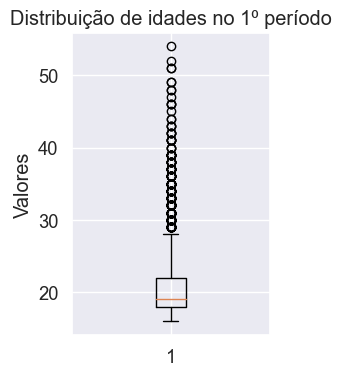

In [100]:
plt.figure(figsize=(3, 4))
plt.boxplot(df.student_age_at_initial_period)
plt.title(f'Distribuição de idades no 1º período')
plt.ylabel('Valores')
plt.tight_layout()
plt.show()

Note que a maior parte dos alunos quando ingressam possuem entre 18 e 23 anos. Existem também muitos outliers, todos aqueles cuja idade de ingresso é superior a 27 anos.

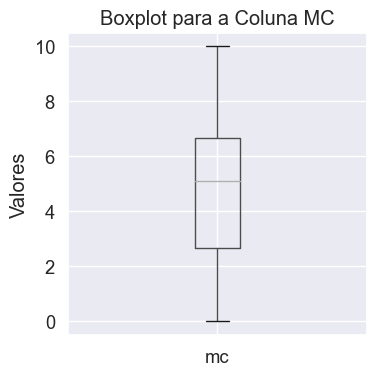

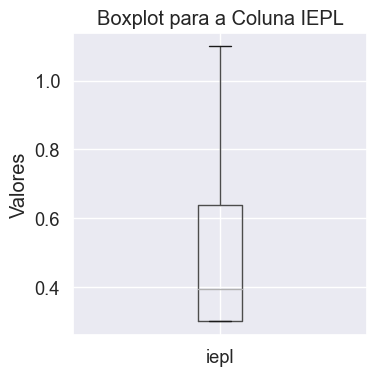

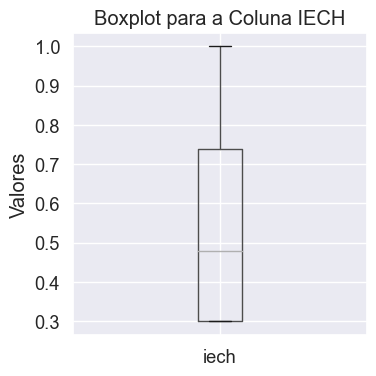

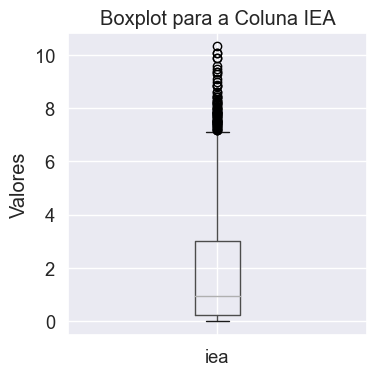

In [101]:
cols = ['mc', 'iepl', 'iech', 'iea']

for column in cols:
    plt.figure(figsize=(4, 4))
    df.boxplot(column)
    plt.title(f'Boxplot para a Coluna {column.upper()}')
    plt.ylabel('Valores')
    plt.tight_layout()
    plt.show()

Nas métricas de desempenhos dos discentes encontramos outliers somente para o atributo do IEA, com valores muito maiores que a mediana.

In [102]:
def classificar_iea(iea, quartis):
    if iea <= quartis[0.25]:
        return 'Grupo 1'
    elif iea <= quartis[0.5]:
        return 'Grupo 2'
    elif iea <= quartis[0.75]:
        return 'Grupo 3'
    else:
        return 'Grupo 4'

In [103]:
quartis = df.iea.quantile([0.25, 0.5, 0.75])
df['classe_iea'] = df.iea.apply(classificar_iea, quartis)

In [104]:
df.groupby('classe_iea')[['mc','locks_number','student_age_at_initial_period','iea']].mean()

,mc,locks_number,student_age_at_initial_period,iea
classe_iea,,,,
Grupo 1,0.866098,0.208909,23.244240,0.077949
Grupo 2,4.396086,0.314330,22.127889,0.521711
Grupo 3,5.797827,0.169492,20.510015,1.846004
Grupo 4,7.321462,0.063077,19.500000,5.084891


Os outliers presentes no conjunto de dados, seja aqueles referentes ao IEA ou a idade de ingresso, fazem parte da variação natural dos dados. Os registros com IEA muito acima da média são, geralmente, de discentes que estão nos primeiros períodos do curso.

In [105]:
df = df.drop(columns=["classe_iea"])

In [106]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


correlation = cramers_v(df.leaving_reason, df.curriculum_status)
print("Cramér's V:", correlation)


Cramér's V: 0.9973666840398321


Remover coluna "curriculum_status", pois é provável que ela tenha o mesmo significado que o atributo alvo

In [107]:
df = df.drop(columns=["curriculum_status"])

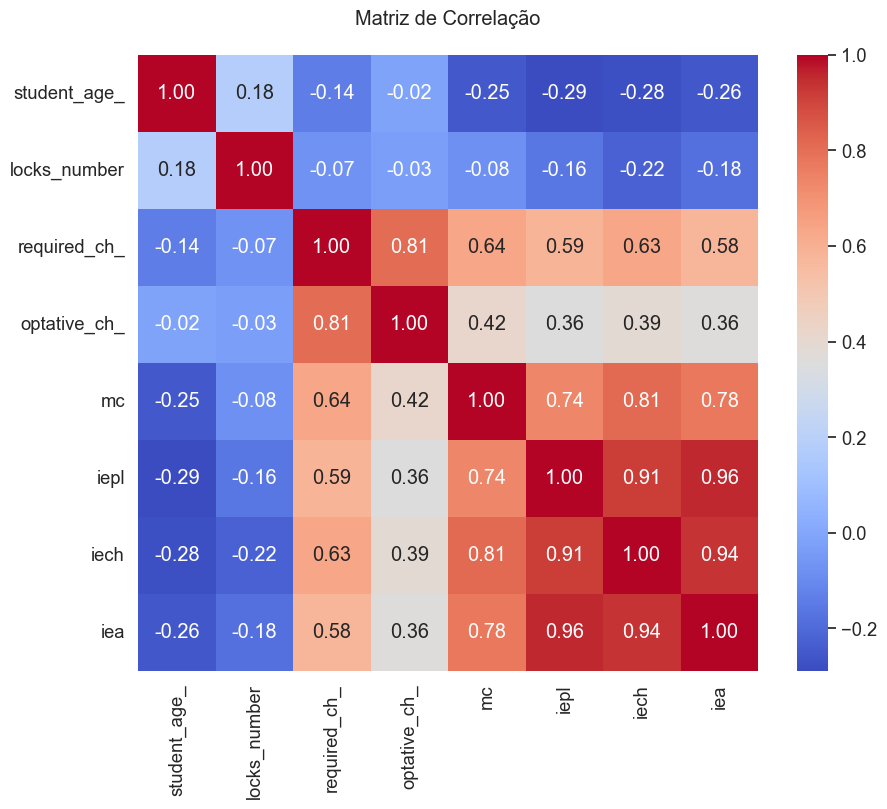

In [108]:
correlation_matrix = df.corr(numeric_only=True)
class_labels = [label[:12] for label in df.select_dtypes(include='number').columns]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Correlação\n')
plt.show()

Existe uma correlação forte positiva entre o percentual créditos optativos e obrigatóricos cursados. Os índices de desempenhos acadêmico também são correlacionados entre si. Isso quer dizer que a utilização de PCA possa ser útil, já que existe mais de uma coluna descrevendo o mesmo comportamento

## Pipeline para Normalização e Categorização dos Dados

In [109]:
df = df.drop(columns=["uf"])

Removendo coluna UF, pois foi constatado que ela não afeta positivamento a precisão do modelo

In [110]:
df['leaving_reason'] = df['leaving_reason'].fillna("ATIVO")

Atribuindo um valor não nulo para a coluna 'leaving_reason'

In [111]:
df.leaving_reason.value_counts()

leaving_reason
ATIVO                                                                                  1076
ABANDONO                                                                                729
CONCLUÍDO                                                                               338
CANC.. NOVO VESTIBULAR                                                                  143
Transferência Interna                                                                   121
CANCELAMENTO ESPONTÂNEO                                                                  76
DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO                                            73
Não atendeu à convocação para o Cadastro Específico conforme Edital 21/2017/PROGRAD      35
TRANSF.P/OUTRA IES                                                                        4
CADASTRO CANCELADO                                                                        2
NÃO CONFIRMAÇÃO VÍNCULO                                          

In [112]:
values_to_keep = ['ATIVO',
                  'ABANDONO',
                  #'CONCLUÍDO',
                  #'CANC.. NOVO VESTIBULAR',
                  #'Transferência Interna',
                  #'CANCELAMENTO ESPONTÂNEO',
                  #'DECURSO DE PRAZO MÁXIMO P/ CONCLUSÃO DE CURSO'
                 ]

df = df[df['leaving_reason'].isin(values_to_keep)]

In [113]:
X, y = df.drop(columns=["leaving_reason"]), df.leaving_reason

Separação dos atributos alvos e preditivos

# Balanceamento dos Dados
## Oversampling SMOTE + Undersampling

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
minor_class_size = y_train.value_counts().min()
major_class_size = y_train.value_counts().max()

In [116]:
classes_counts = dict(y_train.value_counts())
categorical_columns_index = [X_train.columns.get_loc(col) for col in X_train.select_dtypes(include=['object']).columns]

undersampling_threshold = (minor_class_size + major_class_size)//2
oversampling_threshold = (minor_class_size + major_class_size)//2 # Lesser or equal to undersampling threshold

under_strategy = {k:(undersampling_threshold if v >= undersampling_threshold else v) for k,v in classes_counts.items()}
over_strategy = {k:(oversampling_threshold if v <= oversampling_threshold else v) for k,v in under_strategy.items()}

undersampler = RandomUnderSampler(sampling_strategy=under_strategy)
oversampler = SMOTENC(categorical_features=categorical_columns_index, sampling_strategy=over_strategy)

pipeline = Pipeline([
    ('undersampler', RandomUnderSampler(sampling_strategy=under_strategy)),
    ('oversampler', SMOTENC(categorical_features=categorical_columns_index, sampling_strategy=over_strategy))
])

sample_size = min(oversampling_threshold, X_test.shape[0])

X_test = X_test.sample(n=sample_size, random_state=42)
y_test = y_test.sample(n=sample_size, random_state=42)

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

In [117]:
class_size = (minor_class_size + major_class_size)//2
class_size

722

In [118]:
train_set_size = X_train_resampled.shape
train_set_size

(1444, 10)

In [119]:
test_set_size = X_test.shape
test_set_size

(361, 10)

In [120]:
numeric_features = selector(dtype_include=['float64', 'int64'])
categorical_features = selector(dtype_exclude=['float64', 'int64'])

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4))

])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

O pipeline de dados criado separa as colunas numéricas e categóricas e aplica diferentes funções a elas. As colunas de variáveis quantitativas sofrem um preenchimento de valores nulos pela média, normalização dos dados e a redução de dimensionalidade para somente as colunas principais, aquelas que descrevem bem o comportamento dos dados. Já para as colunas de variáveis qualitativas, também é feito o preenchimento de valores nulos pela moda e um processo de codificação denominado One-Hot encoding. Esse processo cria uma coluna bínária para cada classe existente nos atributos categóricos

In [121]:
X_train_resampled_processed = pipeline.fit_transform(X_train_resampled)
X_test_processed = pipeline.transform(X_test)

Esses são os dados transformados e pré-processados:

In [122]:
dados_processados_df = pd.DataFrame(X_train_resampled_processed)

A fim de teste, tentemos treinar um modelo de classificação utilizando o algoritmo Random Forest:

In [123]:
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest_classifier.fit(X_train_resampled_processed, y_train_resampled)

y_pred = random_forest_classifier.predict(X_test_processed)
accuracy = accuracy_score(y_test, y_pred)

print("Acurácia:", accuracy)

Acurácia: 0.7922437673130194


O modelo acima classifica a situação do aluno, se ele evadiu, concluiu ou está cursando dentre as outras alternativas de saída do curso

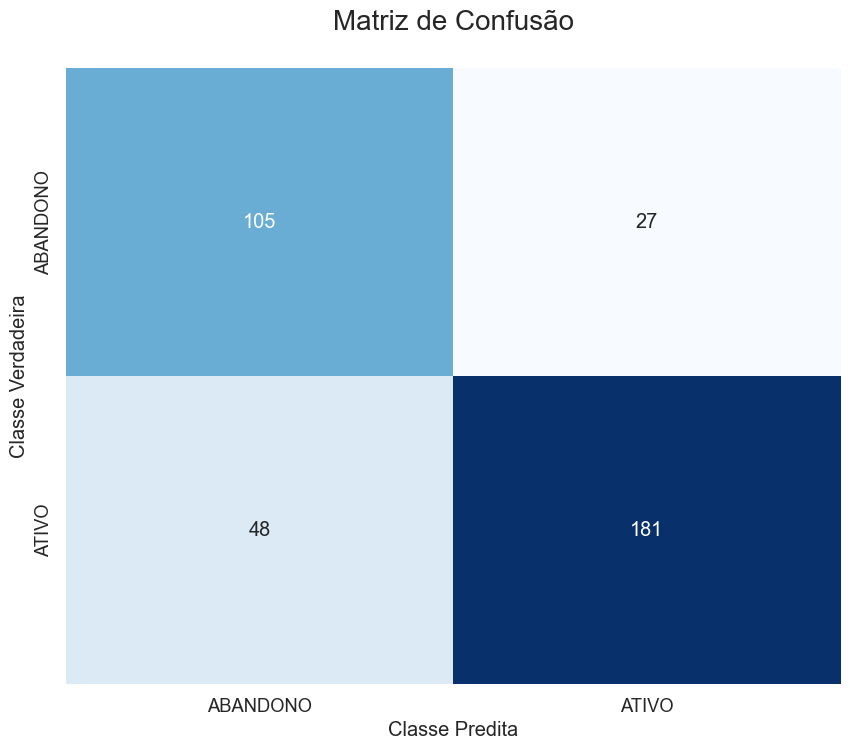

In [124]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

class_labels = [label[:15] for label in y_test.unique()]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão\n', fontsize=20)
plt.show()

# Criação de Modelos de Classificação

In [125]:
def print_metrics(model_name, y_true, y_pred):
    
    print("Model:", model_name)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    print("\n")
    
    
def cross_validate_model(model_name, pipeline, X, y):
    
    print("Model:", model_name)
    cv_scores = cross_val_score(pipeline, X, y, cv=StratifiedKFold(n_splits=3), scoring='accuracy')
    print("Cross Validation Scores:", cv_scores)
    print("Mean Accuracy:", mean(cv_scores))
    print("Standard Deviation of Accuracy:", std(cv_scores))
    print("\n")

    
def plot_confusion_matrix(model_name, pipeline, y_test, y_pred):
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_labels = sorted(label[:15] for label in y_test.unique())
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', cbar=False)
    sns.set(font_scale=1.2)

    plt.title(f'Matriz de Confusão: {model_name}\n', fontsize=20)
    plt.xlabel('Classe Predita')
    plt.ylabel('Classe Verdadeira')
    plt.show()

print_metrics(model_name, y_true, y_pred): Imprime métricas de avaliação de desempenho do. Ele recebe o nome do modelo (model_name), os rótulos verdadeiros (y_true) e as previsões do modelo (y_pred). Ele imprime um relatório de classificação usando a função classification_report do scikit-learn, que inclui métricas como precisão, recall e F1-score para cada classe, bem como a média dessas métricas. Além disso, ele calcula e imprime a precisão geral do modelo.

cross_validate_model(model_name, pipeline, X, y): Esta função realiza a validação cruzada de um modelo. Recebe o nome do modelo (model_name), um pipeline de pré-processamento e modelo (pipeline), as características (X) e os rótulos (y). Ele usa a função cross_val_score do scikit-learn para realizar a validação cruzada com 3 dobras (split) usando StratifiedKFold e calcula a precisão para cada dobra. Em seguida, imprime os resultados, incluindo os escores de validação cruzada, a precisão média e o desvio padrão da precisão.

plot_confusion_matrix(model_name, pipeline, y_test, y_pred): Esta função plota uma matriz de confusão para avaliar o desempenho do modelo de classificação. Recebe o nome do modelo (model_name), o pipeline de pré-processamento e modelo (pipeline), os rótulos verdadeiros de teste (y_test) e as previsões do modelo (y_pred). Ele usa a função confusion_matrix do scikit-learn para calcular a matriz de confusão e a biblioteca Seaborn para plotar a matriz de confusão como um mapa de calor. Isso ajuda na visualização da distribuição de classificações corretas e incorretas feitas pelo modelo.

In [126]:
y_test.value_counts()

leaving_reason
ATIVO       229
ABANDONO    132
Name: count, dtype: int64

Total de registros de cada classes no conjunto de teste

Model: K Vizinhos mais Próximos
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.67      0.84      0.75       132
       ATIVO       0.89      0.76      0.82       229

    accuracy                           0.79       361
   macro avg       0.78      0.80      0.79       361
weighted avg       0.81      0.79      0.80       361

Accuracy: 0.7922437673130194




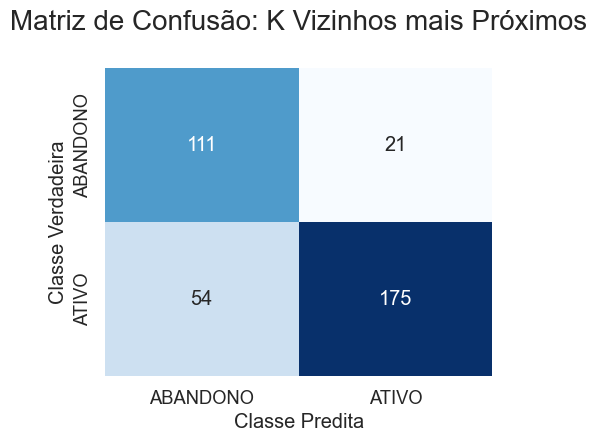

Model: K Vizinhos mais Próximos
Cross Validation Scores: [0.76556017 0.73180873 0.76923077]
Mean Accuracy: 0.7555332223382015
Standard Deviation of Accuracy: 0.01684254375536943


Model: Naive Bayes
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.72      0.31      0.43       132
       ATIVO       0.70      0.93      0.80       229

    accuracy                           0.70       361
   macro avg       0.71      0.62      0.62       361
weighted avg       0.71      0.70      0.67       361

Accuracy: 0.703601108033241




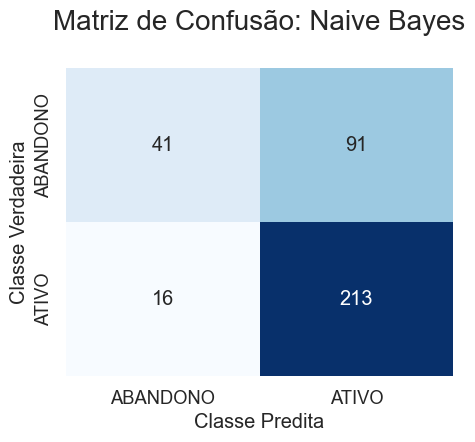

Model: Naive Bayes
Cross Validation Scores: [0.52489627 0.51975052 0.58627859]
Mean Accuracy: 0.5436417905297574
Standard Deviation of Accuracy: 0.03022186778675216


Model: Máquina de Vetor de Suporte
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.68      0.95      0.79       132
       ATIVO       0.96      0.75      0.84       229

    accuracy                           0.82       361
   macro avg       0.82      0.85      0.82       361
weighted avg       0.86      0.82      0.82       361

Accuracy: 0.8199445983379502




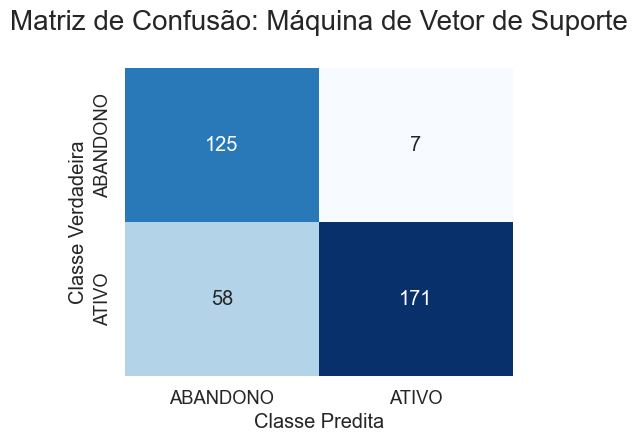

Model: Máquina de Vetor de Suporte
Cross Validation Scores: [0.7780083  0.76507277 0.77338877]
Mean Accuracy: 0.772156612405575
Standard Deviation of Accuracy: 0.005352300030743996


Model: Árvore de Decisão
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.60      0.74      0.66       132
       ATIVO       0.83      0.72      0.77       229

    accuracy                           0.73       361
   macro avg       0.71      0.73      0.72       361
weighted avg       0.75      0.73      0.73       361

Accuracy: 0.7257617728531855




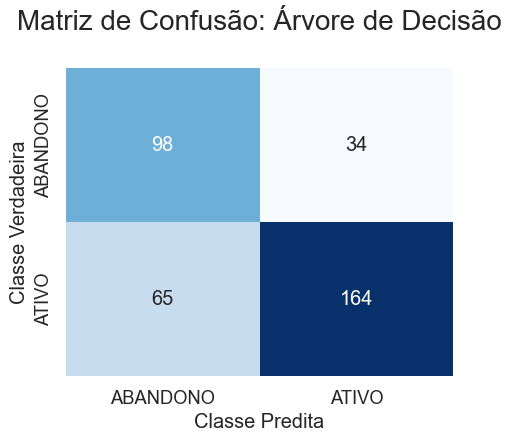

Model: Árvore de Decisão
Cross Validation Scores: [0.69917012 0.71517672 0.71933472]
Mean Accuracy: 0.7112271863309209
Standard Deviation of Accuracy: 0.008692978199987184


Model: Regressão Logística
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.70      0.92      0.79       132
       ATIVO       0.95      0.77      0.85       229

    accuracy                           0.83       361
   macro avg       0.82      0.85      0.82       361
weighted avg       0.86      0.83      0.83       361

Accuracy: 0.8254847645429363




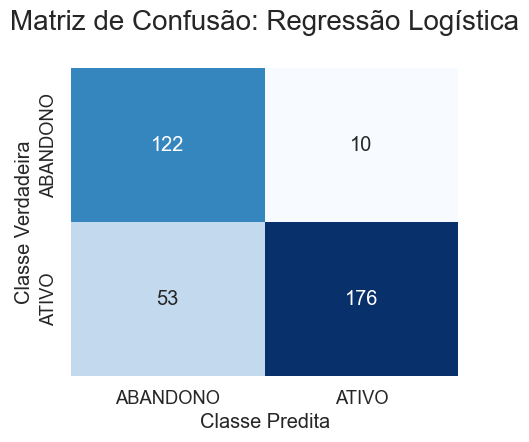

Model: Regressão Logística
Cross Validation Scores: [0.78630705 0.77754678 0.76091476]
Mean Accuracy: 0.7749228641344824
Standard Deviation of Accuracy: 0.010531091348654258




In [127]:
knn_classifier = KNeighborsClassifier()
naive_bayes_classifier = GaussianNB()
svm_classifier = SVC(random_state=42)
decision_tree_classifier = DecisionTreeClassifier(random_state=42)
logistic_classifier = LogisticRegression(solver='lbfgs', max_iter=200, random_state=42)

models = [
    ('K Vizinhos mais Próximos', knn_classifier),
    ('Naive Bayes', naive_bayes_classifier),
    ('Máquina de Vetor de Suporte', svm_classifier),
    ('Árvore de Decisão', decision_tree_classifier),
    ('Regressão Logística', logistic_classifier)
]

pipelines = []
for model_name, model in models:
    pipeline = Pipeline([
        (model_name, model)
    ])
    pipelines.append((model_name, pipeline))

for model_name, pipeline in pipelines:
    pipeline.fit(X_train_resampled_processed, y_train_resampled)
    y_pred = pipeline.predict(X_test_processed)
    print_metrics(model_name, y_test, y_pred)
    plot_confusion_matrix(model_name, pipeline, y_test, y_pred)
    cross_validate_model(model_name, pipeline, X_train_resampled_processed, y_train_resampled)

# Avaliação das métricas de desempenho

Para cada modelo, foram calculados para cada classe a precisão, revocação, f1-score e as médias. Além disso, também foi realizada a validação cruzada estratificada.

## K Vizinhos mais Próximos

Para a classe ABANDONO:
> A precisão é de 70%, o que significa que das instâncias classificadas como ABANDONO, 70% realmente pertencem a essa classe. O recall é de 84%, indicando que o modelo identificou corretamente 84% das instâncias de ABANDONO no conjunto de dados. O f1-score é de 76% para esta classe.

Para a classe ATIVO:
> A precisão é de 90%, o que significa que das instâncias classificadas como ATIVO, 90% são realmente ATIVOS. O recall é de 79%, indicando que o modelo identificou corretamente 79% das instâncias de ATIVO no conjunto de dados. O f1-score é de 84% para esta classe.

A acurácia geral do modelo é de 81%. Os resultados da validação cruzada mostram uma média de acurácia de 73.33%, com um desvio padrão de 0.63%, o que sugere que o modelo tem uma capacidade de generalização razoável para novos dados.

-------------------------------------------------------------------------------------------------------------------------------


## Naive Bayes

Para a classe ABANDONO:
> A precisão é de 79%, o que significa que das instâncias classificadas como ABANDONO, 79% realmente pertencem a essa classe. No entanto, o recall é de apenas 23%, indicando que o modelo identificou corretamente apenas 23% das instâncias de ABANDONO no conjunto de dados. O f1-score é de 35% para esta classe.

Para a classe ATIVO:
> A precisão é de 68%, o que significa que das instâncias classificadas como ATIVO, 68% são realmente ATIVOS. O recall é de 97%, indicando que o modelo identificou corretamente 97% as instâncias de ATIVO no conjunto de dados. O f1-score é de 80% para esta classe.

A acurácia geral do modelo é de 70%. Os resultados da validação cruzada mostram uma média de acurácia de cerca de 57.26%, com um desvio padrão de 9.68%, sugerindo que o modelo tem uma capacidade de generalização limitada para novos dados.

-------------------------------------------------------------------------------------------------------------------------------

## Máquina de Vetor de Suporte

Para a classe ABANDONO:
> A precisão é de 68%, o que significa que das instâncias classificadas como ABANDONO, 68% realmente pertencem a essa classe. O recall é de 92%, indicando que o modelo identificou corretamente 92% das instâncias de ABANDONO no conjunto de dados. O f1-score é de 78% para esta classe.

Para a classe ATIVO:
> A precisão é de 95%, o que significa que das instâncias classificadas como ATIVO, 95% são realmente ATIVOS. O recall é de 75%, indicando que o modelo identificou corretamente 75% das instâncias de ATIVO no conjunto de dados. O f1-score é de 84% para esta classe.

A acurácia geral do modelo é de 81%. Os resultados da validação cruzada mostram uma média de acurácia de cerca de 77.14%, com um desvio padrão de 2.55%, sugerindo que o modelo tem uma capacidade de generalização razoável para novos dados.

-------------------------------------------------------------------------------------------------------------------------------

## Árvore de Decisão

Para a classe ABANDONO:
> A precisão é de 59%, o que significa que das instâncias classificadas como ABANDONO, 59% realmente pertencem a essa classe. O recall é de 67%, indicando que o modelo identificou corretamente 67% das instâncias de ABANDONO no conjunto de dados. O f1-score é de 63% para esta classe.

Para a classe ATIVO:
> A precisão é de 79%, o que significa que das instâncias classificadas como ATIVO, 79% são realmente ATIVOS. O recall é de 73%, indicando que o modelo identificou corretamente 73% das instâncias de ATIVO no conjunto de dados. O f1-score é de 76% para esta classe.

A acurácia geral do modelo é de 71%. Os resultados da validação cruzada mostram uma média de acurácia de cerca de 71.05%, com um desvio padrão de 2.57%, sugerindo que o modelo tem uma capacidade de generalização razoável para novos dados.

-------------------------------------------------------------------------------------------------------------------------------

## Regressão Logística

Para a classe ABANDONO:
> A precisão é de 69%, o que significa que das instâncias classificadas como ABANDONO, 69% realmente pertencem a essa classe. O recall é de 92%, indicando que o modelo identificou corretamente 92% das instâncias de ABANDONO no conjunto de dados. O f1-score é de 79% para esta classe.

Para a classe ATIVO:
> A precisão é de 94%, o que significa que das instâncias classificadas como ATIVO, 94% são realmente ATIVOS. O recall é de 76%, indicando que o modelo identificou corretamente 76% das instâncias de ATIVO no conjunto de dados. O f1-score é de 84% para esta classe.

A acurácia geral do modelo é de 82%. Os resultados da validação cruzada mostram uma média de acurácia de cerca de 77.15%, com um desvio padrão de 1.79%, sugerindo que o modelo tem uma capacidade de generalização razoável para novos dados.

-------------------------------------------------------------------------------------------------------------------------------


## Considerações finais sobre os resultados:

Nenhum dos modelos construídos alcançou um desempenho excelente. Aqueles que apresentaram melhor desempenho foram: K-Vizinhos mais Próximos, Support Vector Machine e Regressão Logística. O Naive-Bayes e Árvore de Decisão tiveram um desempenho ligeiramente inferior, destacando-se negativamente em comparação com os demais.
É importante ressaltar que nenhum desses modelos passou por uma otimização de hiperparâmetros, o que sugere que ainda há espaço para melhorias.

### Visualização da Árvore de Decisão

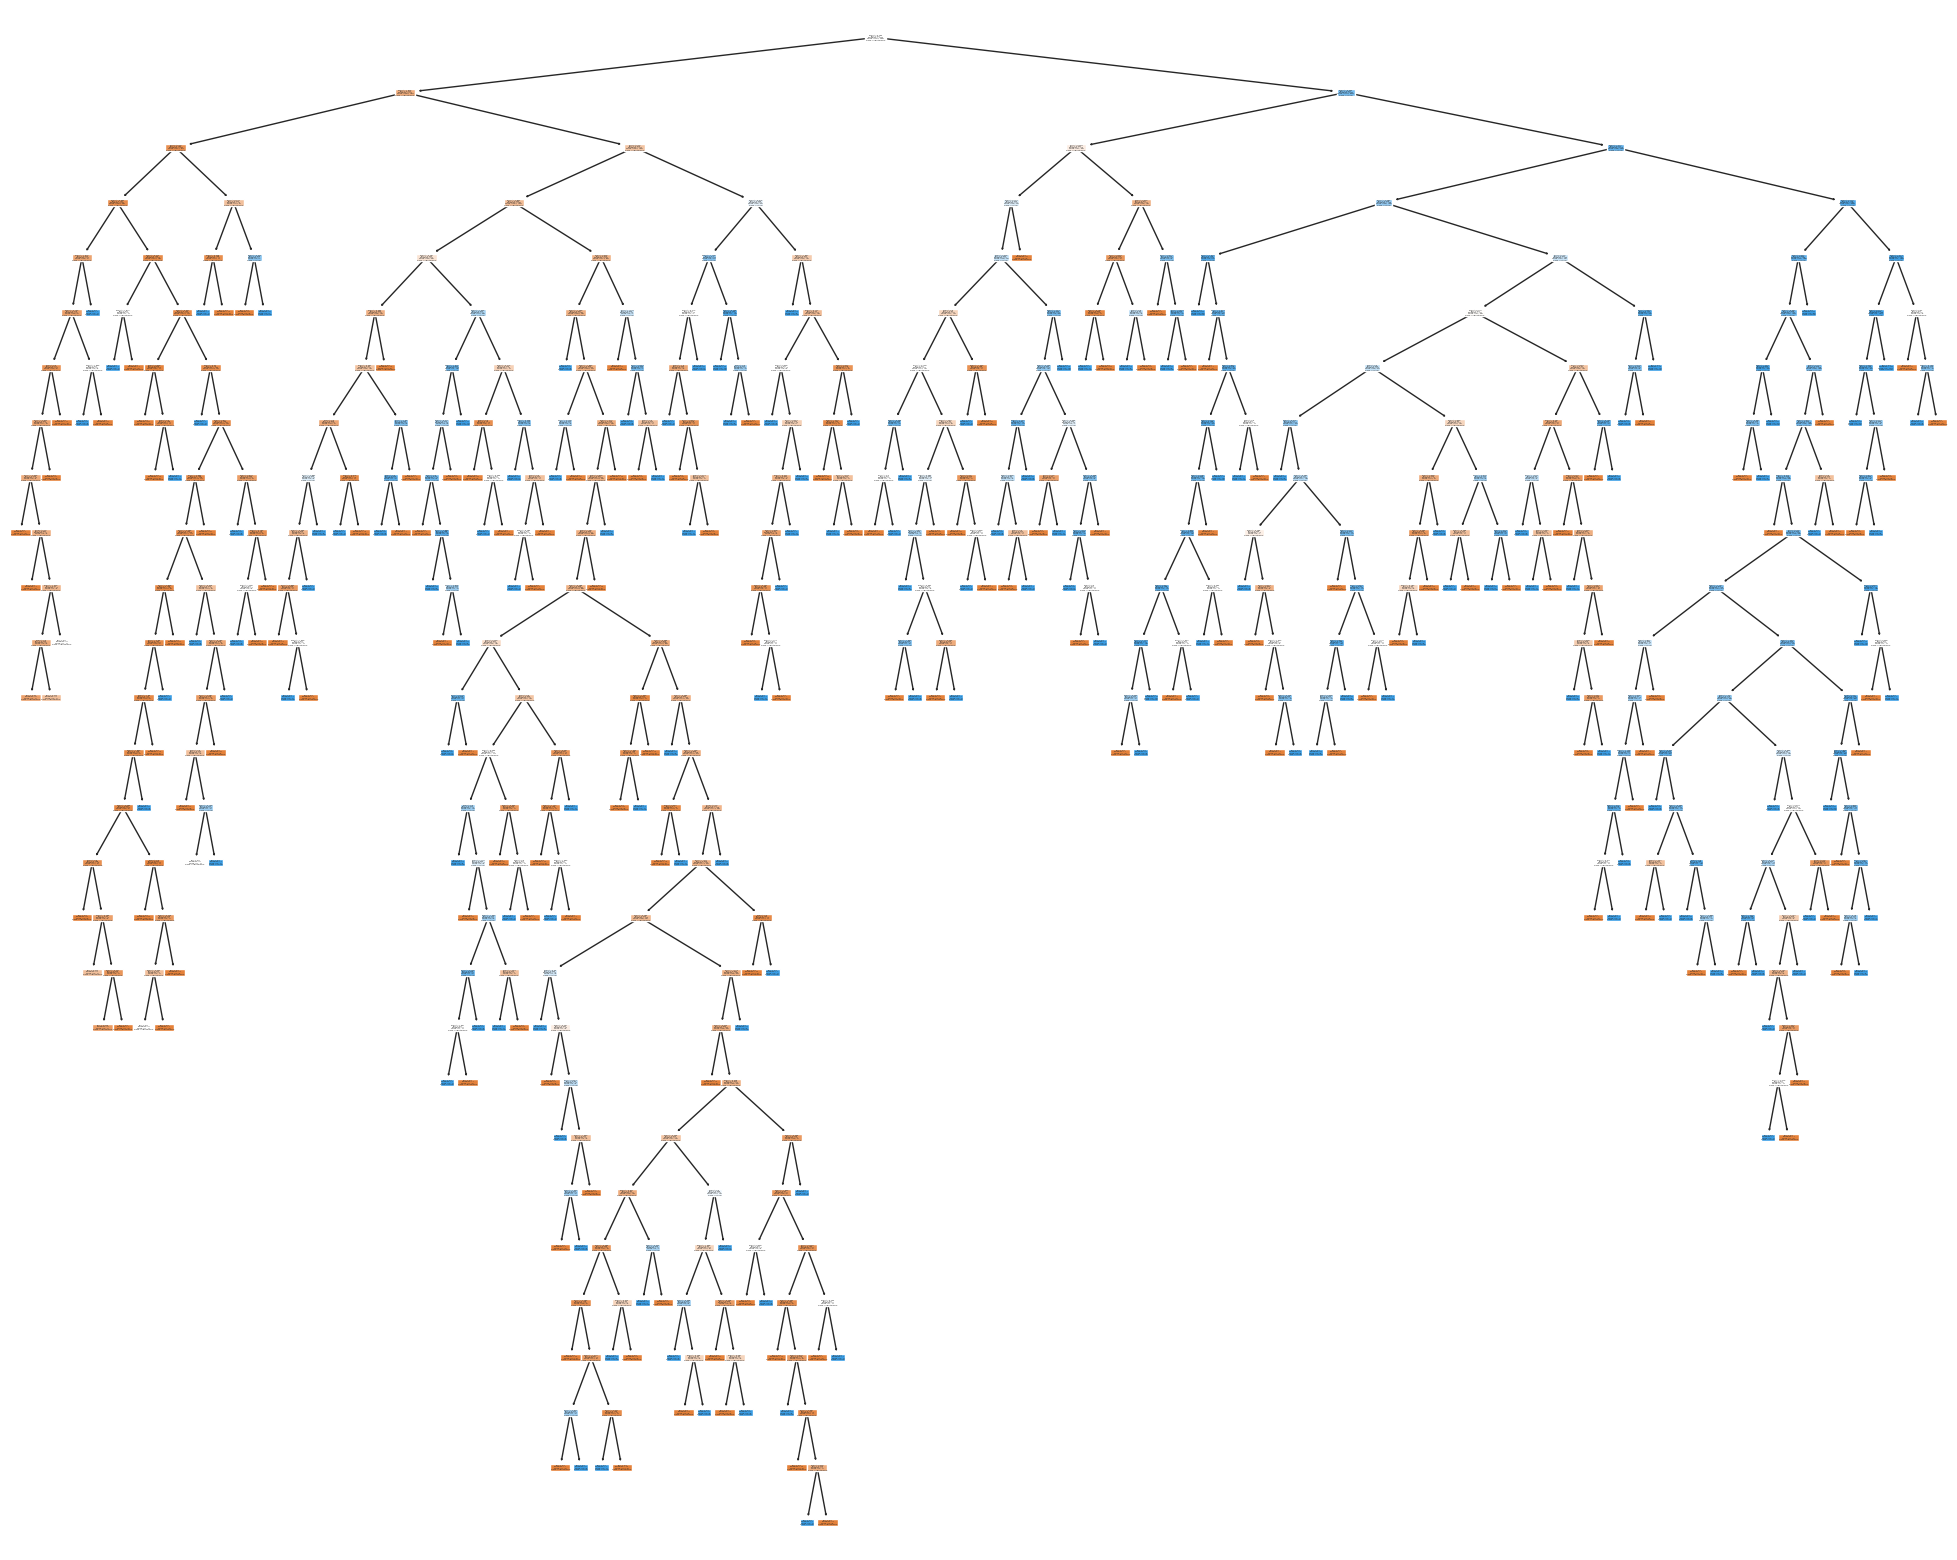

In [128]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(decision_tree_classifier, 
                   class_names=class_labels,
                   filled=True)

# Otimização de Hiperparâmetros
## Busca em Grade

In [129]:
knn_params = {'K Vizinhos mais Próximos__n_neighbors': [3, 5, 7, 9],
              'K Vizinhos mais Próximos__weights': ['uniform', 'distance'],
              'K Vizinhos mais Próximos__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

svm_params = {'Máquina de Vetor de Suporte__C': [0.1, 1, 10],
              'Máquina de Vetor de Suporte__kernel': ['linear', 'rbf'],
              'Máquina de Vetor de Suporte__gamma': ['scale', 'auto']}

decision_tree_params = {'Árvore de Decisão__criterion': ['gini', 'entropy'],
                        'Árvore de Decisão__splitter': ['best', 'random'],
                        'Árvore de Decisão__max_depth': [None, 2, 4, 8, 16, 32, 64, 128]}

param_grid = [
    (knn_params, 'K Vizinhos mais Próximos'),
    (svm_params, 'Máquina de Vetor de Suporte'),
    (decision_tree_params, 'Árvore de Decisão')
]

for params, model_name in param_grid:
    pipeline = dict(pipelines)[model_name]
    grid_search = GridSearchCV(pipeline, params, cv=5, scoring='accuracy')
    grid_search.fit(X_train_resampled_processed, y_train_resampled)
    
    print(f"Melhores hiperparâmetros para {model_name}:")
    print("\n".join(f"{k}: {v}" for k,v in grid_search.best_params_.items()))
    print(f'Melhor Score: {grid_search.best_score_}\n')

Melhores hiperparâmetros para K Vizinhos mais Próximos:
K Vizinhos mais Próximos__algorithm: auto
K Vizinhos mais Próximos__n_neighbors: 9
K Vizinhos mais Próximos__weights: distance
Melhor Score: 0.7742286620530565

Melhores hiperparâmetros para Máquina de Vetor de Suporte:
Máquina de Vetor de Suporte__C: 10
Máquina de Vetor de Suporte__gamma: auto
Máquina de Vetor de Suporte__kernel: rbf
Melhor Score: 0.7714604959630911

Melhores hiperparâmetros para Árvore de Decisão:
Árvore de Decisão__criterion: entropy
Árvore de Decisão__max_depth: 4
Árvore de Decisão__splitter: best
Melhor Score: 0.7610798731257209



In [136]:
knn_classifier = KNeighborsClassifier()
svm_classifier = SVC(probability=True, random_state=42)
dt_classifier  = DecisionTreeClassifier(random_state=42)

knn_classifier_optimized = KNeighborsClassifier(n_neighbors=9, algorithm="auto", weights="distance")
svm_classifier_optimized = SVC(C=10, gamma="scale", kernel="rbf", probability=True, random_state=42)
dt_classifier_optimized  = DecisionTreeClassifier(criterion="entropy", max_depth=4, splitter="best", random_state=42)

In [137]:
def fit_models(models: list, X_train, y_train):
    for model in models:
        model.fit(X_train, y_train)

In [138]:
fit_models([knn_classifier, knn_classifier_optimized,
            svm_classifier, svm_classifier_optimized,
            dt_classifier, dt_classifier_optimized ],
            X_train_resampled_processed, y_train_resampled)

y_pred_knn = knn_classifier.predict(X_test_processed)
y_pred_svm = svm_classifier.predict(X_test_processed)
y_pred_dt = dt_classifier.predict(X_test_processed)

y_pred_knn_op = knn_classifier_optimized.predict(X_test_processed)
y_pred_svm_op = svm_classifier_optimized.predict(X_test_processed)
y_pred_dt_op = dt_classifier_optimized.predict(X_test_processed)

In [139]:
print_metrics("Decision Tree",  y_test, y_pred_dt)
print_metrics("Decision Tree*",  y_test, y_pred_dt_op)

print_metrics("KNN",  y_test, y_pred_knn)
print_metrics("KNN*",  y_test, y_pred_knn_op)

print_metrics("SVM", y_test, y_pred_svm)
print_metrics("SVM*", y_test, y_pred_svm_op)

Model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.60      0.74      0.66       132
       ATIVO       0.83      0.72      0.77       229

    accuracy                           0.73       361
   macro avg       0.71      0.73      0.72       361
weighted avg       0.75      0.73      0.73       361

Accuracy: 0.7257617728531855


Model: Decision Tree*
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.63      0.88      0.74       132
       ATIVO       0.91      0.71      0.80       229

    accuracy                           0.77       361
   macro avg       0.77      0.79      0.77       361
weighted avg       0.81      0.77      0.77       361

Accuracy: 0.7700831024930748


Model: KNN
Classification Report:
              precision    recall  f1-score   support

    ABANDONO       0.67      0.84      0.75       132
       ATIVO       0.89      0.76      0.82       22

# Comparação de Modelos com Hiperparâmetroso Otimizados e
# não-otimizados utilizando curvas ROC

In [140]:
def plot_roc_curve(fpr1, tpr1, auc1, label1, fpr2, tpr2, auc2, label2):
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'{label1} (AUC = {auc1:.2f})')
    plt.plot(fpr2, tpr2, color='red', lw=2, label=f'{label2} (AUC = {auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.show()

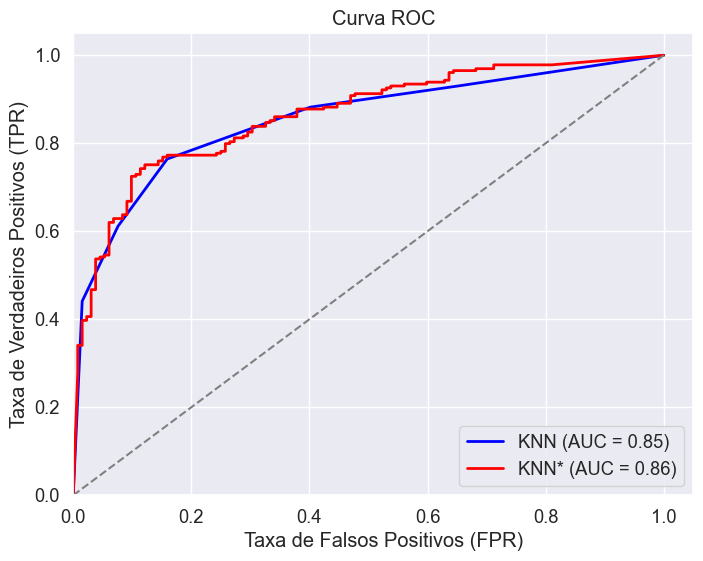

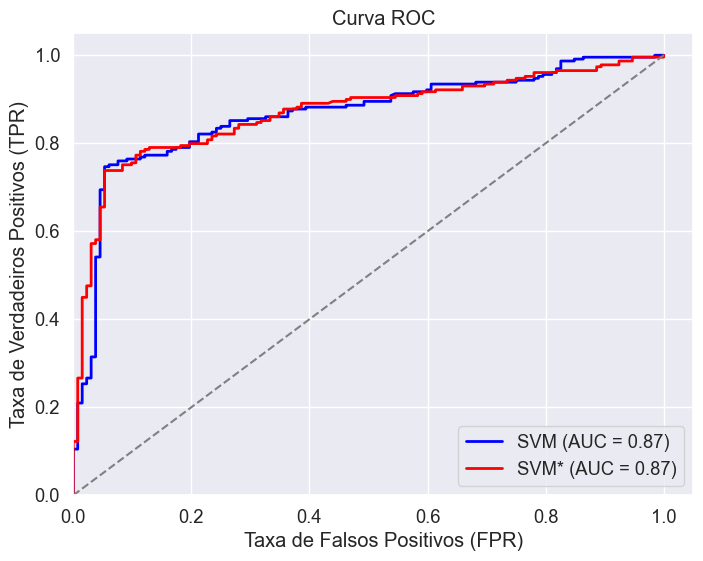

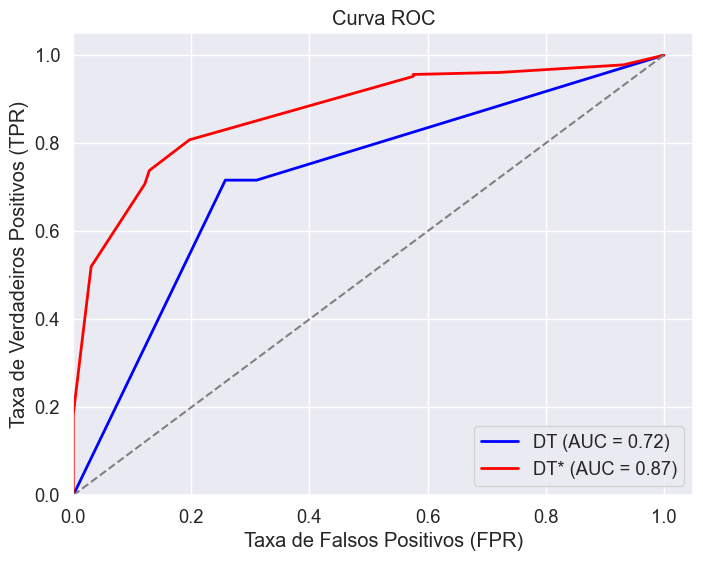

In [141]:
number_of_classes = len(y_test.unique())

if number_of_classes == 2:
    label_encoder = LabelEncoder()
    y_test_binary = label_encoder.fit_transform(y_test)
    
    y_prob_knn = knn_classifier.predict_proba(X_test_processed)[:, 1]
    y_prob_knn_op = knn_classifier_optimized.predict_proba(X_test_processed)[:, 1]
    
    y_prob_svm = svm_classifier.predict_proba(X_test_processed)[:, 1]
    y_prob_svm_op = svm_classifier_optimized.predict_proba(X_test_processed)[:, 1]
    
    y_prob_dt = dt_classifier.predict_proba(X_test_processed)[:, 1]
    y_prob_dt_op = dt_classifier_optimized.predict_proba(X_test_processed)[:, 1]

    
    fpr_knn, tpr_knn, _ = roc_curve(y_test_binary, y_prob_knn)
    fpr_knn_op, tpr_knn_op, _ = roc_curve(y_test_binary, y_prob_knn_op)
    
    fpr_svm, tpr_svm, _ = roc_curve(y_test_binary, y_prob_svm)
    fpr_svm_op, tpr_svm_op, _ = roc_curve(y_test_binary, y_prob_svm_op)
    
    fpr_dt, tpr_dt, _ = roc_curve(y_test_binary, y_prob_dt)
    fpr_dt_op, tpr_dt_op, _ = roc_curve(y_test_binary, y_prob_dt_op)

    
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    roc_auc_knn_op = auc(fpr_knn_op, tpr_knn_op)
    
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    roc_auc_svm_op = auc(fpr_svm_op, tpr_svm_op)

    roc_auc_dt = auc(fpr_dt, tpr_dt)
    roc_auc_dt_op = auc(fpr_dt_op, tpr_dt_op)

    
    plot_roc_curve(fpr_knn, tpr_knn, roc_auc_knn, 'KNN', fpr_knn_op, tpr_knn_op, roc_auc_knn_op, 'KNN*')
    plot_roc_curve(fpr_svm, tpr_svm, roc_auc_svm, 'SVM', fpr_svm_op, tpr_svm_op, roc_auc_svm_op, 'SVM*')
    plot_roc_curve(fpr_dt, tpr_dt, roc_auc_dt, 'DT', fpr_dt_op, tpr_dt_op, roc_auc_dt_op, 'DT*')

Ao analisar as curvas ROC, observa-se que não há uma diferença significativa entre os modelos SVM e KNN. Isso sugere que as configurações padrão dos hiperparâmetros desses modelos produziram resultados tão bons quanto aqueles obtidos após a otimização por meio da busca em grade. Por outro lado, o modelo baseado em Árvore de Decisão inicialmente apresentou um desempenho relativamente baixo. No entanto, após a otimização dos hiperparâmetros, houve uma melhoria substancial na performance, evidenciada pelo aumento de aproximadamente 0.14 da área sob a curva ROC.